# 1. Intro

**FAQ style retrieval based chat bot**
- Train three model types (in different configurations) to figure out user input and map to a response class. Let's see which one does well. The models are
    - a TF-IDF similarity measure doc classifier 
    - a TFIDF based n-gram MLP multi-class classifier (supervised)
    - an RNN classifier (unsupervised)

**The Data**
- Pulling data from known disease/pandemic authorities such as CDC and WHO

- Also getting KE national government content. These are static data; knowledge already in place. TODO: a channel for news updates 

- Data is maintained in a Gsheet and can make updates/additions/etc from there

- Clean and classify the above data to have two datasets
    - FAQ_db: This is the knowledge base. One to one mapping of class categories and response paragraphs. Has two main fields: class_category, response_p. Additional fields: src, src_link 
    - Phrases_db: This is the training set on questions/input that users may present to the bot. Has two main fields: input_phrase, class_category 
    
**Approach**
- Retrieval based chat bot. 


# 2. Corana Dashboard by John Hopkins Uni

[Link to map FAQ](https://coronavirus.jhu.edu/map-faq)

In [1]:
### John Hopkins Dashboard - https://coronavirus.jhu.edu/map.html
from IPython.display import IFrame
## default 77.3846,11.535 
start_coordz = "77.3846,11.535"  # rabat, morocco"33.9693414,-6.9273026"
center_coordz = "28.8189834,-2.5117154" #center Bukavu, DRC "-2.5117154,28.8189834"

IFrame(src="//arcgis.com/apps/Embed/index.html?webmap=14aa9e5660cf42b5b4b546dec6ceec7c&extent="+start_coordz+",163.5174,52.8632"+
       "&center="+center_coordz+
       "&zoom=true&previewImage=false&scale=true&disable_scroll=true&theme=light", 
    width="650", height="400", frameborder="0", scrolling="no", marginheight="0", marginwidth="0", title="2019-nCoV" )

# 3. FAQ Chat bot - Part 1
- Find suitable data and format 

## 3.1. Explore the data 

In [2]:
import numpy as np
import pandas as pd

import nltk

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
sys.path.append("../../../shared") 
import zdataset, zdata_source
from zdataset import ZGsheetFaqDataSet


import warnings
warnings.filterwarnings('ignore')

In [4]:
## plot settings
params = {
    'font.size' : 14.0,
    'figure.figsize': (20.0, 12.0),
    'figure.dpi' : 40
}
plt.rcParams.update(params)
plt.style.use('fivethirtyeight') #tableau-colorblind10 ggplot

In [5]:
## some helper functions @ view db

## requires zdataset object . Forcing Abstract vs gsheet subclass<< TODO reflection at abstract class
def preview_gsheet_faq(db):
    ### What does an faq response record look like
    try:
        k= list(db.faq_db.keys())[0]
        v = db.faq_db[ k ] 
        print( "FAQ db Item: (k ==> v)" )
        print("{} ==> {}".format( k, v   ) )
    except:
        pass
    ### What does a phrase record look like
    try:
        k = list(db.data.keys())[0]
        v = db.data[ k ] 
        print("\n\nPhrases db Item: (k ==> v)") 
        print("{} ==> {}".format( k, v   ) )
    except:
        k = 0
        v = db.data[ k ] 
        print("\n\nPhrases db Item: (k ==> v)") 
        print("{} ==> {}".format( k, v   ) )
        

def show_basic_stats(db_wordz, db_lemmaz, vocab_wordz, vocab_lemmaz):
    print( "1. Wordz: count = {}, sample = {}".format( len(db_wordz), db_wordz[:4]))
    print( "2. Lemmaz: count = {}, sample = {}".format( len(db_lemmaz), db_lemmaz[:4]))

    print( "3. Vocab Wordz: count = {}, sample = {}".format( len(vocab_wordz), vocab_wordz[:4]))
    print( "4. Vocab Lemmaz: count = {}, sample = {}".format( len(vocab_lemmaz), vocab_lemmaz[:4]))

    # lexical diversity
    print( "5. Lemmaz/Wordz ratio = {}".format( len(db_lemmaz) / len(db_wordz) if len(db_wordz) > 0 else 'N/A' ))
    print( "6. Vocab/Wordz ratio = {}".format(  len(vocab_wordz) / len(db_wordz) if len(db_wordz) > 0 else 'N/A') ) 
    print( "7. Vocab/Lemmaz ratio = {}".format( len(vocab_lemmaz)/len(db_lemmaz) if len(db_lemmaz) > 0 else 'N/A') )
    
## given a sequence do FreqDist and report
def doFreqDist( list_text ):
    fq = nltk.FreqDist( list_text )
    print( "FreqDist of {} tokens.".format( fq.N() ) )
    print( "Top 10 common tokens: \n{}".format( fq.most_common(10) ) )
    # plot most common
#     fq.plot( 15) 
    return fq

## plot multiple seqence in same 
## returns top most_fq_n words for if we want to clean further
def fq_plotMultiple(fqz, namez, most_fq_n=15):
    colz = ['token', 'freq']    
    
    df = pd.DataFrame( fqz[0].most_common(most_fq_n), columns=['token', 'freq'])
    df['dset'] = namez[0]
    
    for i, fq in enumerate(fqz[1:]):        
        j = i+1
        tmp = pd.DataFrame( fq.most_common(most_fq_n), columns=['token', 'freq'])
        tmp['dset'] = namez[j] 
        df = pd.concat([df, tmp])
#         print( "{}: shape: {}, columns: {} Sample: \n{}".format(namez[j], tmp.shape, tmp.columns, tmp.head(2), )) 
    
#     print( "FIN>>> shape: {}, columns: {} Sample: \n{}".format( df.shape, df.columns, df.head(2), ))     
    g = sns.barplot( x='token', y='freq', hue='dset', dodge=False, data=df)
    g.set_title("Top {} words distribution by dataset allocation".format(most_fq_n))
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='center')
#     plt.xticks( rotation = 45)
    plt.legend(loc='upper right')
    plt.show()
    
    return df

In [6]:
print('nb.load_data', "Loading Gsheet FAQ db")
faq_path = [ ('1EuvcPe9WXSQTsmSqhq0LWJG4xz2ZRQ1FEdnQ_LQ-_Ks', 'FAQ responses!A1:G1000'), ('1EuvcPe9WXSQTsmSqhq0LWJG4xz2ZRQ1FEdnQ_LQ-_Ks', 'Classify_Phrases!A1:G1000')]
faq_typ = zdata_source.zGSHEET_FAQ


dset = ZGsheetFaqDataSet()
dset.initFromResource(faq_path, faq_typ)  
dset.preprocess()     
dlen =  len(dset.clean_data) 
dwords = dset.getWords()
dvocab = dset.getVocab()
print( "Tokens len: recs={}, words={}, vocab={}\n{}\n".format(dlen, len(dwords), len(dvocab), dset.clean_data[: min(dlen, 10) - 1 ] ) ) 

nb.load_data Loading Gsheet FAQ db
Tokens len: recs=141, words=1167, vocab=320
['what is a pandemic' 'what cause pandemic'
 'what doe it mean that who ha declared a pandemic'
 'why do pandemic occur' 'how serious will the impact be'
 'what are corona virus' 'what is covid19 virus' 'what is corana 19 virus'
 'what is ncov19 virus']



In [7]:
### What does an faq response and phrase record look like
preview_gsheet_faq(dset)

FAQ db Item: (k ==> v)
pandemic_define ==> ['A pandemic is an epidemic (infectious disease outbreak) that spreads on a global scale. Pandemics usually occur when a new infectious disease emerges that can spread rapidly around the world.\r\n\r\nThe World Health Organization (WHO) declared the outbreak of COVID-19 a pandemic on 11 March 2020. This COVID-19 pandemic is the first caused by a coronavirus. (WHO)', 'Australian Govt', 'https://www.health.nsw.gov.au/Infectious/alerts/Pages/coronavirus-faqs.aspx#8-1']


Phrases db Item: (k ==> v)
0 ==> what is a pandemic?


## 3.2. Preprocessing & Stats on the data

Data refers to the phrases, on which user input is determined. 

**Preprocessing**
- Clean: words to lower, remove punkts, keep numbers.
- Option to lemmatize or use phrases as is.
- Remove words that are common within this corpus



**Data Stats** 
- number of records, train Vs test
- lexical diversity, train Vs test 
- 


In [19]:
### clean_data_and_lemmatize Vs no lemmatized.
## at this point it's just bag of words. @model can decide if BOW or Sequence
###### UPDATES after EDA rounds
## - remove stop words and numbers

dict_preprocess_argz = {
    'remove_stopwordz' : True, 
    'remove_numberz' : True
}

## 1. no_lemmatization
dset.preprocess( lemmatized=False, **dict_preprocess_argz )
db_wordz = np.copy( dset.getWords() )
vocab_wordz = np.copy(  dset.getVocab() )
# print("\n================== ON TO LEMMATIZATION ===============")
## 2. yes lemmatization 
dset.preprocess( lemmatized=True, **dict_preprocess_argz)
db_lemmaz = dset.getWords()
vocab_lemmaz = dset.getVocab()

## 3. Show full db stats
show_basic_stats(db_wordz, db_lemmaz, vocab_wordz, vocab_lemmaz)


1. Wordz: count = 544, sample = ['pandemic' 'causes' 'pandemics' 'declared']
2. Lemmaz: count = 544, sample = ['pandemic', 'cause', 'pandemic', 'declared']
3. Vocab Wordz: count = 270, sample = ['access' 'adhere' 'adults' 'affected']
4. Vocab Lemmaz: count = 254, sample = ['access', 'adhere', 'adult', 'affected']
5. Lemmaz/Wordz ratio = 1.0
6. Vocab/Wordz ratio = 0.4963235294117647
7. Vocab/Lemmaz ratio = 0.46691176470588236


In [20]:
## 4. Split train and test 
print( "Size = {}".format( len(dset.clean_data) ) )
db_train, db_test = dset.splitIntoTrainTest()

## 3. Show train, test stats
for i, db in enumerate([db_train, db_test]) :
    print("\n {0} {1} Dataset {0}".format("-"*5, "train" if i == 0 else "test"))
#     preview_gsheet_faq(db)
    print( "Size = {}".format( len(db.data) ) )
    
    ## 1. no_lemmatization
    db.preprocess( lemmatized=False, **dict_preprocess_argz)
    db_wordz = np.copy( db.getWords() )
    vocab_wordz = np.copy( db.getVocab() )

    ## 2. yes lemmatization 
    db.preprocess( lemmatized=True, **dict_preprocess_argz)
    db_lemmaz = np.copy( db.getWords() )
    vocab_lemmaz = np.copy( db.getVocab() )
    
    show_basic_stats(db_wordz, db_lemmaz, vocab_wordz, vocab_lemmaz)



INFOR   : 2020-04-07 01:14:18.448027 [splitTrainTest] Provided data size = 141
pandemic


Size = 141

 ----- train Dataset -----
Size = 113
1. Wordz: count = 430, sample = ['case' 'child' 'community' 'covid']
2. Lemmaz: count = 430, sample = ['case' 'child' 'community' 'covid']
3. Vocab Wordz: count = 223, sample = ['access' 'adhere' 'adult' 'affected']
4. Vocab Lemmaz: count = 223, sample = ['access' 'adhere' 'adult' 'affected']
5. Lemmaz/Wordz ratio = 1.0
6. Vocab/Wordz ratio = 0.5186046511627908
7. Vocab/Lemmaz ratio = 0.5186046511627908

 ----- test Dataset -----
Size = 28
1. Wordz: count = 113, sample = ['come' 'contact' 'contanct' 'identified']
2. Lemmaz: count = 113, sample = ['come' 'contact' 'contanct' 'identified']
3. Vocab Wordz: count = 88, sample = ['adult' 'area' 'away' 'blood']
4. Vocab Lemmaz: count = 88, sample = ['adult' 'area' 'away' 'blood']
5. Lemmaz/Wordz ratio = 1.0
6. Vocab/Wordz ratio = 0.7787610619469026
7. Vocab/Lemmaz ratio = 0.7787610619469026


In [21]:
## Compare freq of top n words; default n = 15
namez = ['all', 'train', 'test']

def getFreqDist(dbz, dbnamez=namez):
    fqz = []    
    ## Frequency Distributions
    fqz.append( doFreqDist( list(dbz[0].getWords() ) ) )

    ## @ train, test 
    for i, db in enumerate(dbz[1:]) :
        print("\n {0} {1} Dataset {0}".format("-"*5, "train" if i == 0 else "test"))
        fqz.append( doFreqDist( list(db.getWords() ) ) )
    
    most_wordz = fq_plotMultiple( fqz, namez)
    
    return most_wordz

FreqDist of 544 tokens.
Top 10 common tokens: 
[('covid', 36), ('virus', 27), ('risk', 10), ('child', 9), ('spread', 8), ('sanitizer', 8), ('hand', 7), ('corana', 6), ('im', 6), ('infected', 6)]

 ----- train Dataset -----
FreqDist of 430 tokens.
Top 10 common tokens: 
[('covid', 30), ('virus', 23), ('child', 8), ('infected', 6), ('protect', 6), ('risk', 6), ('spread', 6), ('sanitizer', 6), ('long', 5), ('im', 5)]

 ----- test Dataset -----
FreqDist of 113 tokens.
Top 10 common tokens: 
[('covid', 6), ('risk', 4), ('virus', 4), ('safe', 4), ('cat', 2), ('dog', 2), ('make', 2), ('pet', 2), ('case', 2), ('school', 2)]


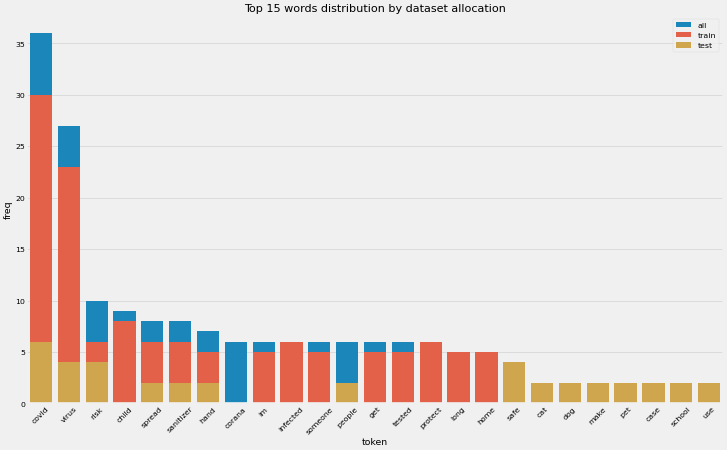

In [22]:
most_wordz = getFreqDist( [dset, db_train, db_test] )

## 3.3. Final clean up; Vectorize/Model use ready


In [12]:
###### 1. remove words that are common within this corpus
# most_wordz.head() <<< TODO
new_stopz = dset.getStopWords(['covid', 'risk']) 

dict_preprocess_argz = {
    'remove_stopwordz' : True, 
    'remove_numberz' : True, 
    'stop_wordz' : new_stopz
}

In [13]:
##### 2. CHECK THRESHOLD : RATIO of n_observations / avg_words_per_observation
##    - If less than 1500 then use n-gram approach 
##    - ElIf 1500 < x < use sequence e.g. SepCNN with existing embeddings
##    - Else use sequence and learn embeddings from scratch 

t_ratio = dset.thresholdRatio()
print( "Threshold Ratio: {}".format( t_ratio))

Threshold Ratio: 36.345521023766


In [14]:
####. 3 Regenerate 
## Can lemmatize iff n-gram 
## n-gram range on cleaned data ???
dset.preprocess( lemmatized=(t_ratio <= 1500), **dict_preprocess_argz) 

## new stats 
dlen =  len(dset.clean_data) 
dwords = dset.getWords()
dvocab = dset.getVocab()
print( "AFTER Tokens len: recs={}, words={}, vocab={}\n{}\n".format(dlen, len(dwords), len(dvocab), dset.clean_data[: min(dlen, 3) - 1 ] ) ) 
# lexical diversity
print( "Vocab/Wordz ratio = {}".format(  len(dvocab) / len(dwords) if len(dwords) > 0 else 'N/A') ) 


db_train, db_test = dset.splitIntoTrainTest()
print("AFTER: train size = {}, test size = {}".format(
        len( db_train.getWords() ),
        len( db_test.getWords() )
    ))

INFOR   : 2020-04-07 01:14:11.073178 [splitTrainTest] Provided data size = 141
pandemic


AFTER Tokens len: recs=141, words=534, vocab=253
['pandemic' 'cause pandemic']

Vocab/Wordz ratio = 0.4737827715355805
AFTER: train size = 423, test size = 111


FreqDist of 534 tokens.
Top 10 common tokens: 
[('covid', 36), ('virus', 27), ('child', 9), ('spread', 8), ('sanitizer', 8), ('hand', 7), ('corana', 6), ('im', 6), ('infected', 6), ('someone', 6)]

 ----- train Dataset -----
FreqDist of 423 tokens.
Top 10 common tokens: 
[('covid', 30), ('virus', 23), ('child', 7), ('tested', 6), ('use', 6), ('hand', 6), ('sanitizer', 6), ('spread', 6), ('get', 5), ('protect', 5)]

 ----- test Dataset -----
FreqDist of 111 tokens.
Top 10 common tokens: 
[('covid', 6), ('virus', 4), ('pandemic', 3), ('people', 3), ('make', 3), ('arrangement', 2), ('checking', 2), ('place', 2), ('screening', 2), ('infection', 2)]


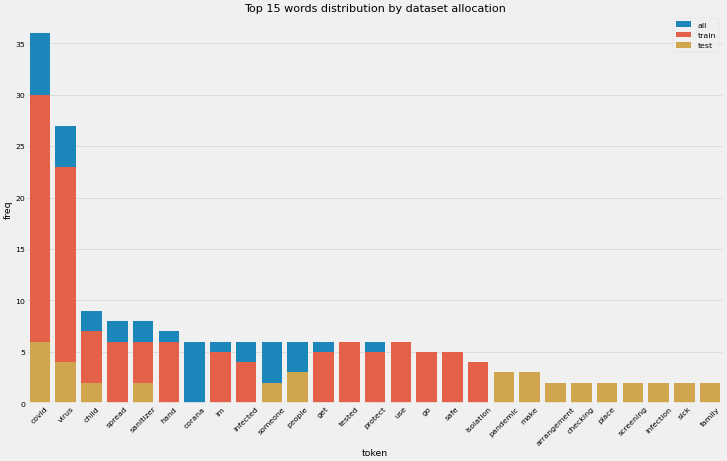

In [15]:
## Compare freq of top n words; default n = 15
most_wordz = getFreqDist( [dset, db_train, db_test] )

## 3.4 Save for modelling

In [16]:
dset.dumpSave('cleaned_phrases', zdata_source.zSERIALIZED)


INFOR   : 2020-04-07 01:14:11.421248 [dataSource.writeTo] dpath = cleaned_phrases.xftz
INFOR   : 2020-04-07 01:14:11.422274 [dataSource.writeTo] dpath = cleaned_phrases.xidx
INFOR   : 2020-04-07 01:14:11.424270 [dataSource.writeTo] dpath = cleaned_phrases.ylbz
INFOR   : 2020-04-07 01:14:11.424270 [dataSource.writeTo] dpath = cleaned_phrases.argz
INFOR   : 2020-04-07 01:14:11.425237 [dataSource.writeTo] dpath = cleaned_phrases.stpz
INFOR   : 2020-04-07 01:14:11.426237 [dataSource.writeTo] dpath = cleaned_phrases.faqdb
INFOR   : 2020-04-07 01:14:11.428230 [dataSource.writeTo] dpath = cleaned_phrases.phrdb


In [17]:
print("Example Featurez: {}".format( dset.clean_data[:3] ) )
print("Example Label: {}".format( dset.y_labelz[:3] ) )

print("Example Featurez: {}".format( dset.clean_data[-1:] ) )
print("Example Label: {}".format( dset.y_labelz[-1:] ) )

Example Featurez: ['pandemic' 'cause pandemic' 'mean declared pandemic']
Example Label: ['pandemic_define' 'pandemic_causes' 'pandemic_WHO']
Example Featurez: ['make cat dog pet sick']
Example Label: ['pets_infection_cdc']


In [18]:
# TODO: 
## Don't know why the stop words are failing and yet the last stop has the correct list :( 
## set a seed at shuffle dataset for train ,test split 